# LEIDY TATIANA ROJAS FORERO - C0923904

# 1. Description of the dataset and Preprocessing steps.
Intel Image Classification : The data is available in Kaggle in the next link:
https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data


In [1]:
# Set up the environment
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Intel dataset
!kaggle datasets download -d puneet6060/intel-image-classification -p /content

# Unzip the ZIP file
!unzip /content/intel-image-classification.zip -d /content/intel-image-classification



Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/intel-image-classific

This dataset contains 25,000 labeled images of natural and urban landscapes, categorized into six classes:

*   Buildings
*   Forest
*   Glacier
*   Mountain
*   Sea
*   Street

Each image is colored (RGB) and varies in resolution. The dataset is structured into three main folders:

*   seg_train: used for training and validation.
*   seg_test: used for final evaluation.
*   seg_pred: optional, for testing predictions on unlabeled data.


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Trainig data
train_datagen = ImageDataGenerator(rescale = 1./255, # Normalize pixel values between 0 and 1
                                   rotation_range=20, # Randomly rotate images up to 20 degress
                                   width_shift_range=0.1, #Random horizontal shifts
                                   height_shift_range=0.1, #Random Vertical shifts
                                   shear_range=0.2, # Simulates small geometric distortions
                                   zoom_range=0.2,  #Random zoom up to 20%
                                   horizontal_flip=True, #Random horizontal flipping
                                   validation_split=0.2) #Reserve 20% data for validation

training_set=train_datagen.flow_from_directory('/content/intel-image-classification/seg_train/seg_train',
                                               target_size=(150,150), #size
                                               batch_size=32,
                                               class_mode='categorical', # Multiclass problem
                                               subset='training'
                                               )
#validation data
validation_set=train_datagen.flow_from_directory('/content/intel-image-classification/seg_train/seg_train',
                                               target_size=(150,150), #size
                                               batch_size=32,
                                               class_mode='categorical', # Multiclass problem
                                               subset='validation'
                                                 )
print(training_set.class_indices)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


To enhance the model's ability to generalize, data augmentation techniques were applied using `ImageDataGenerator`. These include:

*   Random rotation (±20 degrees)
*   Horizontal and vertical shifting
*   Zooming and shearing
*   Horizontal flipping

The train data was split into training (80%) and validation (20%) subsets using ImageDataGenerator with rescaling to normalize pixel values between 0 and 1.






Test data was loaded separately, using ImageDataGenerator with rescaling to normalize pixel values between 0 and 1.

In [4]:
#Testing data
test_datagen = ImageDataGenerator(rescale = 1./255) # Normalize pixel values between 0 and 1

test_set=test_datagen.flow_from_directory('/content/intel-image-classification/seg_test/seg_test',
                                               target_size=(150,150), #size
                                               batch_size=32,
                                               class_mode='categorical', # Multiclass problem
                                               shuffle=False)

print(test_set.class_indices)

Found 3000 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}



*   Trainig set: 11230
*   Validation set: 2804
*   Testing set: 3000






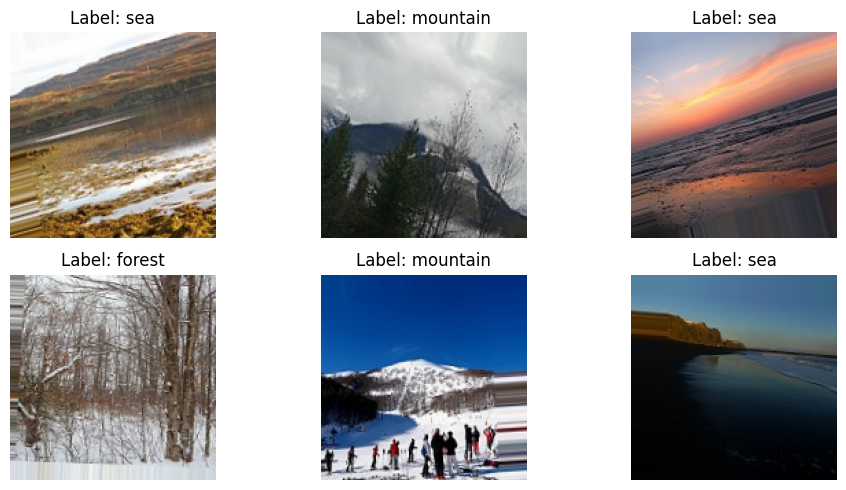

In [5]:
# Display Sample Images
class_names = list(training_set.class_indices.keys())
x_batch, y_batch = next(training_set)

plt.figure(figsize=(10, 5))
for i in range(6): # 6 sample data
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    label = class_names[np.argmax(y_batch[i])]
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Model Building

The CNN was built using Keras Sequential API with the following structure:

*   2 Convolutional Layers with ReLU activation (filters=64 and 96 respectively, kernel_size=3)
*   2 MaxPooling Layers to reduce spatial dimensions
*   Dropout Layer (0.4) to reduce overfitting
*   Flatten Layer
*   2 Fully Connected (Dense) Layers with 128 and 64 units respectively, with relu activation
*   Output Layer with softmax activation for 6-class prediction

In [6]:
# model building
cnn=tf.keras.models.Sequential() #Intializing the model

# add convolutional layer 1
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[150,150,3]))
# add pooling layer 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# add convolutional layer 2
cnn.add(tf.keras.layers.Conv2D(filters=96, kernel_size=3, activation='relu'))
# add pooling layer 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#dropout
cnn.add(tf.keras.layers.Dropout(0.4))
# flatten the layer
cnn.add(tf.keras.layers.Flatten())

# fully connected layer 1
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# fully connected layer 2
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))

# output layer
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 124416)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,925,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,991,206 (61.00 MB)

 Trainable params: 15,991,206 (61.00 MB)

 Non-trainable params: 0 (0.00 B)

The model has a total of 15,991,206 trainable parameters, the majority of which come from the first fully connected layer. This indicates a model of moderate complexity, capable of capturing rich representations from the input images, but still efficient enough for training on standard hardware.

# 3. Model Training

To train the model, I compiled and trained with:

*   Loss function: categorical_crossentropy
*   Optimizer: Adam
*   Metrics: accuracy
*   The model was trained for  20 epochs with validation monitoring.

Adam optimizer adjust the network weights during training to minimize the loss function.


In [7]:
#compile model
cnn.compile(
    loss='categorical_crossentropy', #is multiclass problem
    optimizer=Adam(),
    metrics=['accuracy']
)

#train model
history = cnn.fit(
    training_set,
    validation_data=validation_set,
    epochs=20,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 254ms/step - accuracy: 0.4447 - loss: 1.3986 - val_accuracy: 0.6241 - val_loss: 1.0009
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.6503 - loss: 0.9224 - val_accuracy: 0.6758 - val_loss: 0.8341
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.7094 - loss: 0.7854 - val_accuracy: 0.7414 - val_loss: 0.7278
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.7397 - loss: 0.7135 - val_accuracy: 0.7496 - val_loss: 0.6911
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.7553 - loss: 0.6635 - val_accuracy: 0.7796 - val_loss: 0.6281
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.7530 - loss: 0.6577 - val_accuracy: 0.7589 - val_loss: 0.6599
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.7730 - loss: 0.6075 - val_accuracy: 0.7992 - val_loss: 0.6022
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 240ms/step - accuracy: 0.7858 - loss: 0

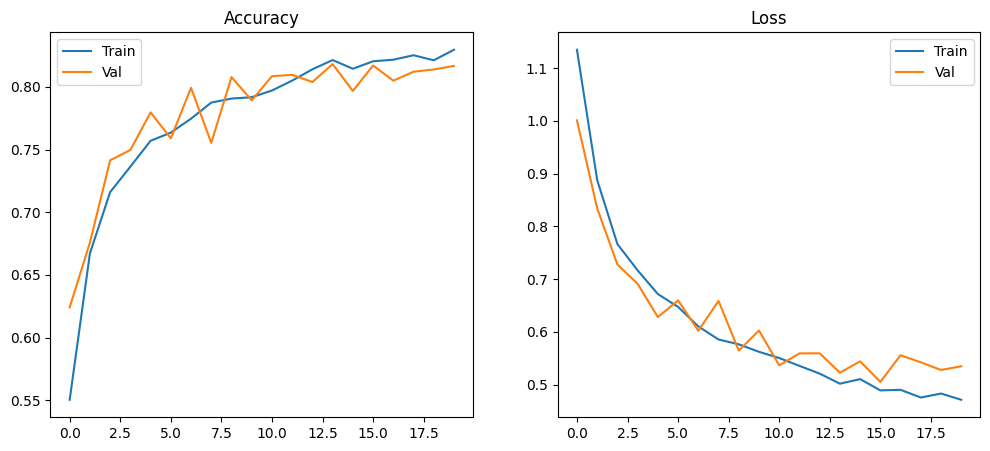

In [8]:
# Plot Accuracy and Loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

Accuracy: The validation curve (orange) closely follows the training curve, indicating improved generalization. Both curves reach values close to 82%, with no clear signs of overfitting.

Loss (right): Steadily decreasing, indicating that the model is learning from the data.


# 4. Model Evaluation

To model Evaluation I used training data.

*   Displey Test Accuracy
*   Classification Report showed precision, recall, and F1-score for all six classes.
*   Confusion Matrix for all classes






94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8129 - loss: 0.5146
Test Accuracy: 0.82
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
              precision    recall  f1-score   support

   buildings       0.86      0.76      0.80       437
      forest       0.90      0.98      0.94       474
     glacier       0.84      0.70      0.77       553
    mountain       0.70      0.83      0.76       525
         sea       0.85      0.82      0.83       510
      street       0.82      0.85      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



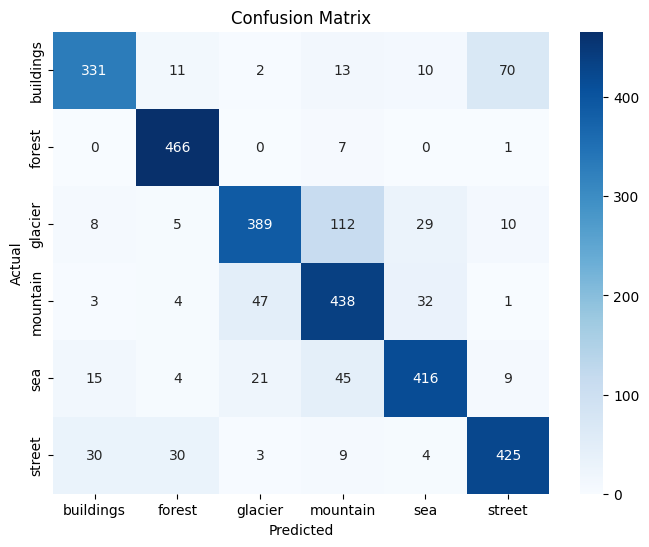

In [9]:
# Evaluate on Test Set
loss, acc = cnn.evaluate(test_set)
print(f"Test Accuracy: {acc:.2f}")

#Classification Report and Confusion Matrix
y_pred = cnn.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
idx_to_class = {v: k for k, v in training_set.class_indices.items()}

print(classification_report(y_true, y_pred_classes, target_names=idx_to_class.values()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test Accuracy: 82 %

Precision/Recall/F1-Score per class: All values range from 0.70 to 0.98, indicating that the model:
*   Is correctly predicting majority classes
*   Has low bias toward any specific class

Macro avg and weighted avg around 0.82 → Overall consistency in performance per class


Confusion Matrix visualized correct and incorrect predictions.
The model correctly classifies most images in each category.

*  Forest, mountain and Strret classes show strong diagonals (high true positives).
*  Buildings vs Street has some confusion: 70 building images were predicted as street.
*  Glacier vs Mountain also shows confusion, 112 glacier images were predicted as a mountain which is reasonable due to visual similarity.



**Improvements**
Tuning architecture or using pre-trained models:

*   Pre-trained models (Transfer Learning): Models like VGG16, ResNet, or MobileNet can significantly boost performance with less training time.
*   Tune hyperparameters: Experiment with learning rate, batch size, optimizer type (e.g., SGD with momentum), etc.
*   Add more aggressive data augmentation: Apply color jitter, brightness/contrast changes, or random cropping for better generalization.
*   Use Batch Normalization: Helps stabilize and speed up training, and reduces sensitivity to initialization.

# 5. Visualization and Interpretation

Below are some misclassified images, with their respective real and predicted labels.

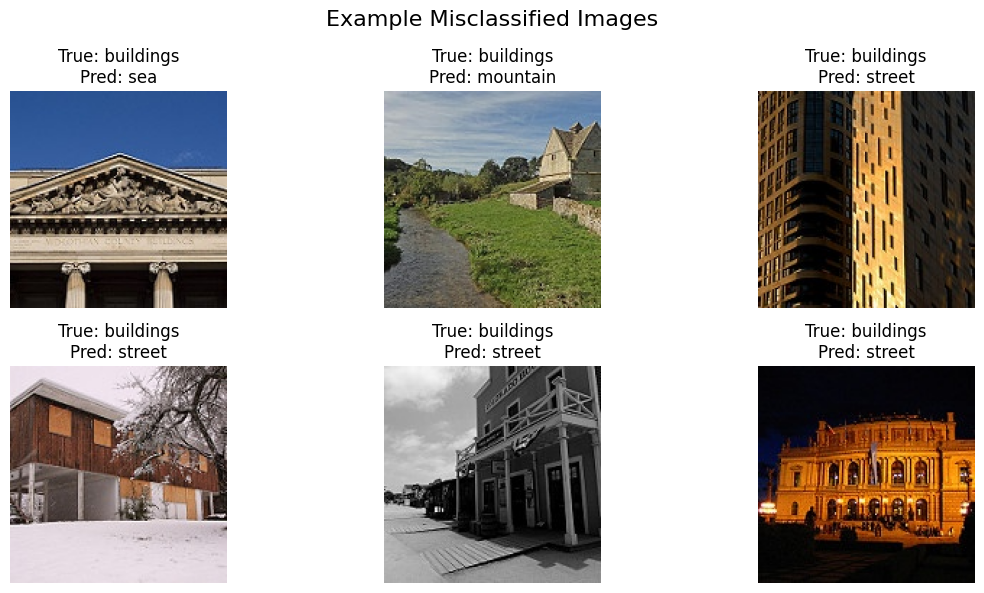

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Identify misclassified indices
errors = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(errors[:6]):

    # Load image from actual file path
    img_path = os.path.join(test_set.directory, test_set.filenames[idx])
    img = load_img(img_path, target_size=(150,150))

    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[y_pred_classes[idx]]

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Example Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()

The images show images of buildings that the model erroneously predicted as street, mountain, and sea. As seen in the confusion matrix, the model misunderstands these categories, likely due to the background.

Finally, a detailed visualization of the feature maps (activation maps) of the first convolutional layer of the CNN model is made.

Filter only those that have "conv" in the name (convolutional layers).

conv2d: (3, 3, 3, 64)
conv2d_1: (3, 3, 64, 96)


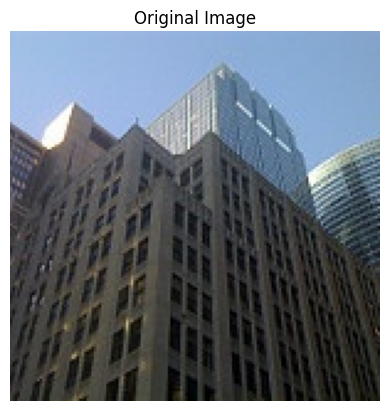

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


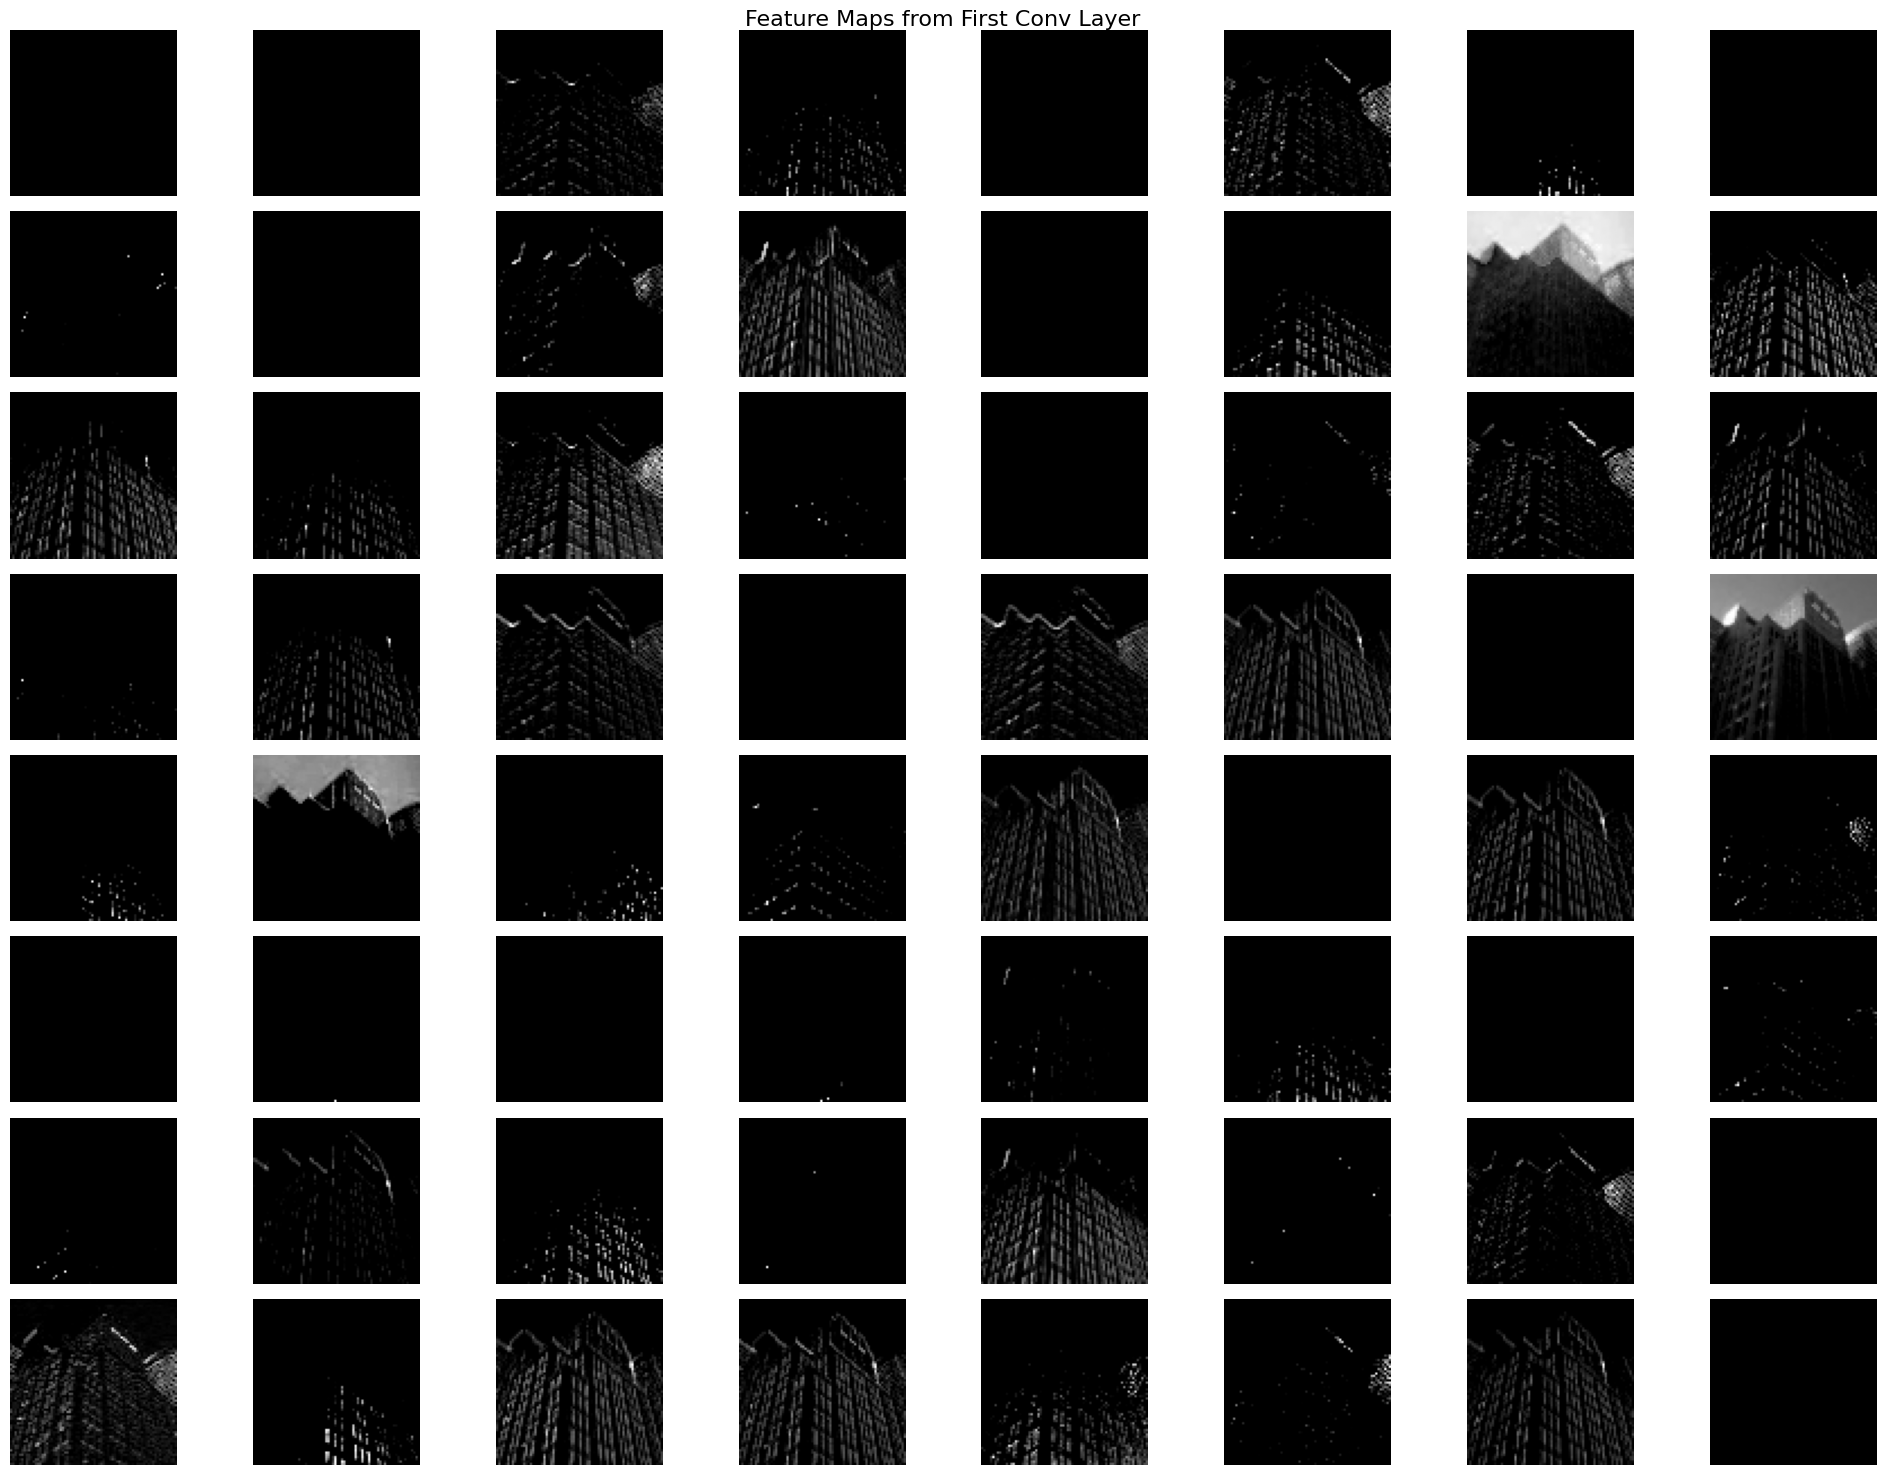

In [ ]:
# Map Visualization
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt

# Loop to display filter shapes of convolutional layers
for layer in cnn.layers:
    if 'conv' not in layer.name:
        continue
    filters, bias = layer.get_weights()
    print(f"{layer.name}: {filters.shape}")

# Build a new model that outputs the activations of the first conv layer
feature_model = Model(inputs=cnn.inputs, outputs=cnn.layers[1].output)

# Load the first image path from the training set
img_path = f"{training_set.directory}/{training_set.filenames[0]}"
img = plt.imread(img_path)

# Show the original image
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Resize and normalize the image to match input shape (150x150x3)
img_resized = np.expand_dims(img, axis=0) / 255.0

# Get feature maps
features = feature_model.predict(img_resized)

# Plot all feature maps
fig = plt.figure(figsize=(20, 15))
for i in range(min(features.shape[-1], 64)):  # limit to first 64 filters
    plt.subplot(8, 8, i + 1)
    plt.imshow(features[0, :, :, i], cmap='gray')
    plt.axis('off')

plt.suptitle("Feature Maps from First Conv Layer", fontsize=16)
plt.tight_layout()
plt.show()


Original image: Building with straight lines, vertical structures, and clear geometric textures. This is ideal for a convolutional network to capture edges and repetitive patterns.

**Feature maps:** Each small box in the grid is the response of a filter (neuron) in the first convolutional layer. There are 64 filters working here ( filters=64 in the first layer).

*   Some maps are completely dark → the filter did not detect anything useful for that image.
*   Others have white borders and highlighted structures → these filters are activating specific regions such as: Vertical lines (building columns), corners, window textures or shadows



This allows to see what basic patterns the model learns at the beginning of the classification process. The first layers typically detect:

Edges

Lines

Contrast

Simple shapes

In deeper layers (not visible here), the network learns more complex combinations, such as "window + roof" or "forest + light."

# Submission Guidelines
https://github.com/TatiRojasF/Intel-Image-Classification